In [19]:
import numpy as np # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import roc_curve, auc, mean_squared_error, confusion_matrix, accuracy_score, plot_confusion_matrix, f1_score, recall_score, precision_score
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score, train_test_split, StratifiedKFold
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE

from numpy import mean, std

import scipy
from scipy import stats
from scipy.stats import norm, skew, boxcox
from collections import Counter


#XGBOOST
from xgboost import XGBClassifier

#warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("heart_failure_clinical_records_dataset.csv")
pd.options.display.max_columns = None

In [6]:
#########################################
#### Exploratory Analysis ###############
#########################################

print("Data Columns --> ",data.columns)
print(data.describe())
print(data.isna().sum())
print(data.info())

Data Columns -->  Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')
              age     anaemia  creatinine_phosphokinase    diabetes  \
count  299.000000  299.000000                299.000000  299.000000   
mean    60.833893    0.431438                581.839465    0.418060   
std     11.894809    0.496107                970.287881    0.494067   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                116.500000    0.000000   
50%     60.000000    0.000000                250.000000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               7861.000000    1.000000   

       ejection_fraction  high_blood_pressure      platelets  \
count         299.000000           

min age : 40.0 
max age : 95.0


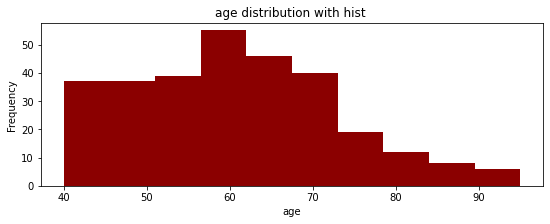

min creatinine_phosphokinase : 23 
max creatinine_phosphokinase : 7861


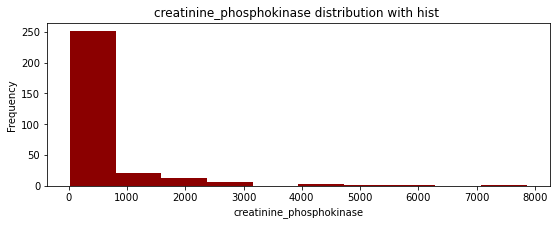

min ejection_fraction : 14 
max ejection_fraction : 80


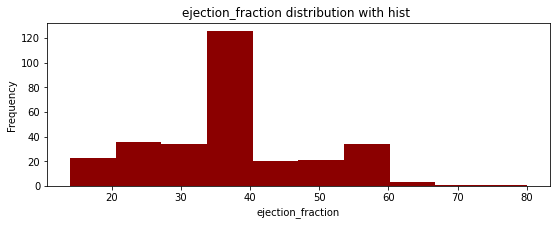

min platelets : 25100.0 
max platelets : 850000.0


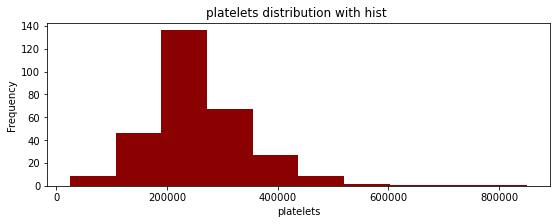

min serum_creatinine : 0.5 
max serum_creatinine : 9.4


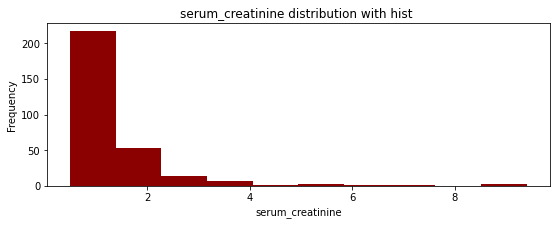

min serum_sodium : 113 
max serum_sodium : 148


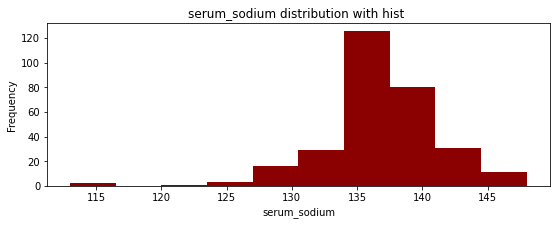

min time : 4 
max time : 285


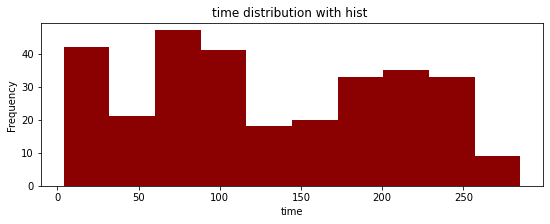

In [4]:
# Plot Histogram of continuous variables in the dataset
def plot_hist(variable):
    print("min {} : {} ".format(variable, min(data[variable])))
    print("max {} : {}".format(variable, max(data[variable])))

    plt.figure(figsize=(9, 3))
    plt.hist(data[variable], color="darkred")
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist ".format(variable))
    plt.show()
    
numericVar = ["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium","time"]
for n in numericVar:
    plot_hist(n)

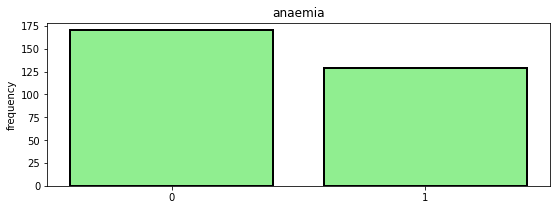

anaemia: 
 0    170
1    129
Name: anaemia, dtype: int64


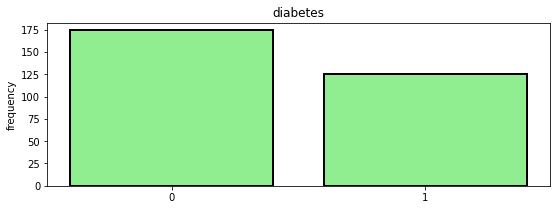

diabetes: 
 0    174
1    125
Name: diabetes, dtype: int64


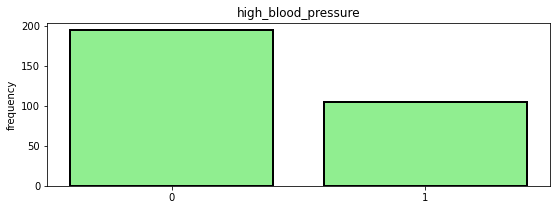

high_blood_pressure: 
 0    194
1    105
Name: high_blood_pressure, dtype: int64


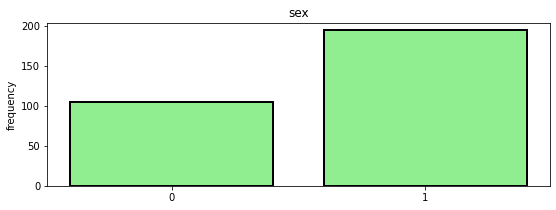

sex: 
 1    194
0    105
Name: sex, dtype: int64


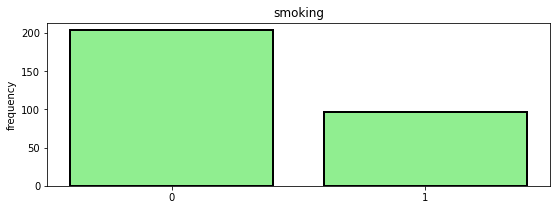

smoking: 
 0    203
1     96
Name: smoking, dtype: int64


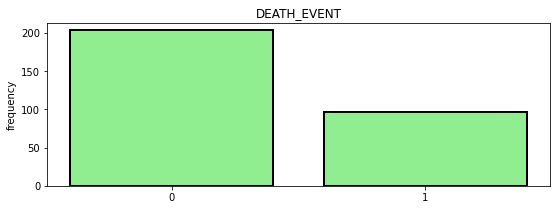

DEATH_EVENT: 
 0    203
1     96
Name: DEATH_EVENT, dtype: int64


In [5]:
# Display bar charts of categorical variables in the dataset
def bar_plot(variable):
    var = data[variable]
    varValue = var.value_counts()

    # visualize
    plt.figure(figsize=(9, 3))
    plt.bar(varValue.index, varValue, color="lightgreen", edgecolor="black", linewidth=2)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("frequency")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable, varValue))


category = ["anaemia","diabetes","high_blood_pressure","sex","smoking","DEATH_EVENT"]
for c in category:
    bar_plot(c)

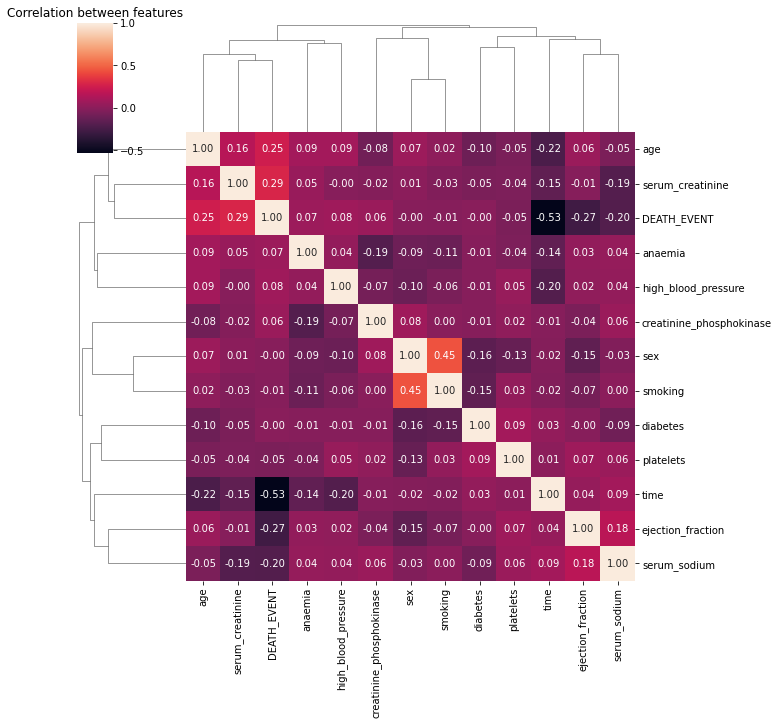

In [7]:
# Display correlation between the features in the dataset
corr_matrix = data.corr()
sns.clustermap(corr_matrix, annot = True, fmt = ".2f")
plt.title("Correlation between features")
plt.show()

In [8]:
#Detect and remove outliers present in the continuous variables 
def detect_outliers(df, features):
    outlier_indices = []

    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c], 25)
        # 3st quartile
        Q3 = np.percentile(df[c], 75)
        # IQR
        IQR = Q3 - Q1
        # Outlier Step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 1)

    return multiple_outliers


print("Outliers detected in the dataset: ", data.loc[detect_outliers(data,["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium","time"])])
print(data.info())
data = data.drop(detect_outliers(data,["age","creatinine_phosphokinase","ejection_fraction",
                                       "platelets","serum_creatinine","serum_sodium","time"]),
                 axis = 0).reset_index(drop=True)
print(data.info())

Outliers detected in the dataset:        age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
38   60.0        0                      2656         1                 30   
52   60.0        0                      3964         1                 62   
163  50.0        1                      2334         1                 35   
200  63.0        1                      1767         0                 45   
296  45.0        0                      2060         1                 60   
217  54.0        1                       427         0                 70   
117  85.0        1                       102         0                 60   
167  59.0        0                        66         1                 20   
281  70.0        0                       582         0                 40   
4    65.0        1                       160         1                 20   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
38                     0  305000.00      

In [9]:
# Calculate skewness of variables
skewed_feats = data.apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness = pd.DataFrame(skewed_feats, columns = ["skewed"])
print(skewness)

                            skewed
creatinine_phosphokinase  4.827396
serum_creatinine          4.605615
platelets                 1.429547
DEATH_EVENT               0.797132
smoking                   0.729243
high_blood_pressure       0.583959
ejection_fraction         0.546146
age                       0.413840
diabetes                  0.358569
anaemia                   0.286636
time                      0.125442
sex                      -0.663509
serum_sodium             -0.855445


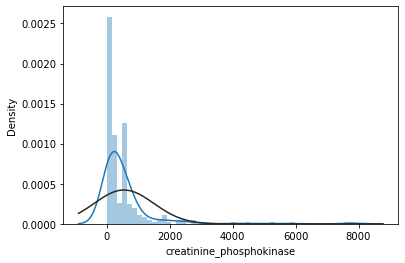

mean creatinine_phosphokinase : 553.121107266436, stdev creatinine_phosphokinase : 943.411428667967


In [11]:
# Plot the distribution with a histogram, kernel density estimate
# and maximum likelihood gaussian distribution fit of the continuous variables
sns.distplot(data["creatinine_phosphokinase"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(data["creatinine_phosphokinase"])
print("mean {} : {}, stdev {} : {}".format("creatinine_phosphokinase", mu, "creatinine_phosphokinase", sigma))

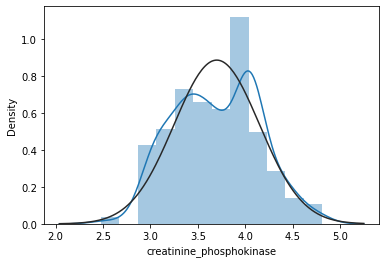

mu creatinine_phosphokinase : 3.698843171315633, sigma creatinine_phosphokinase : 0.4504255141000855


In [12]:
data["creatinine_phosphokinase"], lam = boxcox(data["creatinine_phosphokinase"])
sns.distplot(data["creatinine_phosphokinase"], fit = norm)
plt.show()
(mu, sigma) = norm.fit(data["creatinine_phosphokinase"])
print("mu {} : {}, sigma {} : {}".format("creatinine_phosphokinase", mu, "creatinine_phosphokinase", sigma))

In [13]:
data["serum_creatinine"], lam_serum_creatine = boxcox(data["serum_creatinine"])

data["ejection_fraction"], lam_ejection_fraction = boxcox(data["ejection_fraction"])

data["platelets"], lam_platelets = boxcox(data["platelets"])

skewed_feats = data.apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness_new = pd.DataFrame(skewed_feats, columns = ["skewed"])
print(skewness_new)

                            skewed
DEATH_EVENT               0.797132
smoking                   0.729243
high_blood_pressure       0.583959
age                       0.413840
diabetes                  0.358569
anaemia                   0.286636
platelets                 0.153154
time                      0.125442
creatinine_phosphokinase  0.038332
serum_creatinine         -0.005096
ejection_fraction        -0.005676
sex                      -0.663509
serum_sodium             -0.855445


In [69]:
################################
##### MACHINE LEARNING #########
################################

X = data.drop("DEATH_EVENT", axis = 1)
y = data.DEATH_EVENT

# Apply SMOTE to dataset for class balancing
sm = SMOTE(random_state=42)
X_sm, Y_sm = sm.fit_resample(X, y)

# Split dataset into training and testing 
test_size = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X_sm, Y_sm, test_size = test_size, random_state = 42)

GAUSSIAN PROCESS CLASSIFICATION USING 1**2 * RBF(length_scale=1) KERNEL


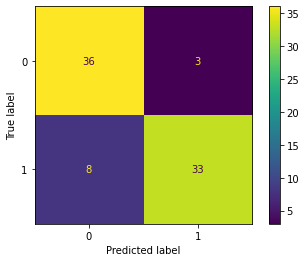

-------------------------------------
GAUSSIAN PROCESS CLASSIFICATION USING 1**2 * DotProduct(sigma_0=1) KERNEL


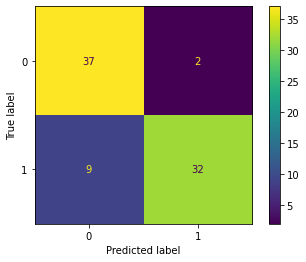

-------------------------------------
GAUSSIAN PROCESS CLASSIFICATION USING 1**2 * Matern(length_scale=1, nu=1.5) KERNEL


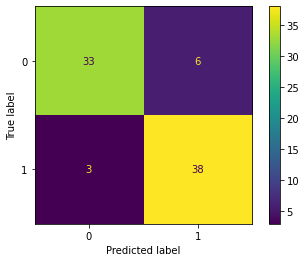

-------------------------------------
GAUSSIAN PROCESS CLASSIFICATION USING 1**2 * RationalQuadratic(alpha=1, length_scale=1) KERNEL


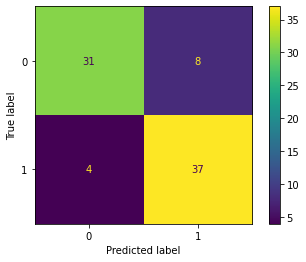

-------------------------------------
GAUSSIAN PROCESS CLASSIFICATION USING 1**2 * WhiteKernel(noise_level=1) KERNEL


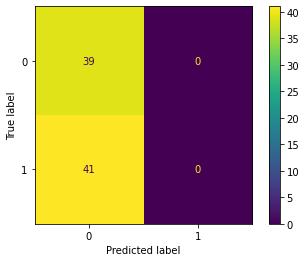

-------------------------------------


In [70]:
#######################################
##### Gaussian Process Classifier #####
#######################################

gp_kernel = [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(), 1*WhiteKernel()]

kernel_accuracy = []
kernel_f1_score = []
kernel_precision = []
kernel_recall = []
kernel_auc = []

for kernel in gp_kernel:
    gp_model = GaussianProcessClassifier(kernel=kernel, max_iter_predict=200)
    gp_model.fit(X_train, Y_train)
    y_hat_gp = gp_model.predict(X_test)
    acc_gp = accuracy_score(Y_test, y_hat_gp)
    f1score_gp = f1_score(Y_test, y_hat_gp)
    precision_gp = precision_score(Y_test, y_hat_gp)
    recall_gp = recall_score(Y_test, y_hat_gp)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_hat_gp)
    roc_auc_gp = auc(false_positive_rate, true_positive_rate)
    
    kernel_f1_score.append(f1score_gp)
    kernel_accuracy.append(acc_gp)
    kernel_precision.append(precision_gp)
    kernel_recall.append(recall_gp)
    kernel_auc.append(roc_auc_gp)
    
    print("GAUSSIAN PROCESS CLASSIFICATION USING %s KERNEL" % str(kernel))
    plot_confusion_matrix(gp_model, X_test, Y_test)
    plt.show()
    print("-------------------------------------")

In [72]:
kernel_results = pd.DataFrame({"Models":["RBF",
                                  "Dot Product",
                                  "Matern",
                                  "Rational Quadratic",
                                  "White Kernel"], 
                               "Model Accuracy": kernel_accuracy, 
                               "Model F1-Score": kernel_f1_score, 
                               "Model Precision": kernel_precision, 
                               "Model ROC AUC:": kernel_auc})

print("Kernel Accuracy")
print(kernel_results)

Kernel Accuracy
               Models  Model Accuracy  Model F1-Score  Model Precision  \
0                 RBF          0.8625        0.857143         0.916667   
1         Dot Product          0.8625        0.853333         0.941176   
2              Matern          0.8875        0.894118         0.863636   
3  Rational Quadratic          0.8500        0.860465         0.822222   
4        White Kernel          0.4875        0.000000         0.000000   

   Model ROC AUC:  
0        0.863977  
1        0.864603  
2        0.886492  
3        0.848655  
4        0.500000  


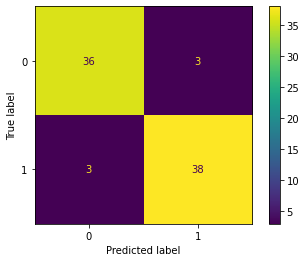

Random Forest Model Accuracy score:  0.925
Random Forest Model F1-score:  0.926829268292683
Random Forest Model Precision score:  0.926829268292683
Random Forest Model Recall score:  0.926829268292683
Random Forest Model ROC AUC score:  0.9749843652282676


In [75]:
#####################################
##### Random Forest Classifier ######
#####################################

rf_model = RandomForestClassifier()
rf_model.fit(X_train, Y_train)
importance = rf_model.feature_importances_

y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(Y_test, y_pred_rf)
f1_rf = f1_score(Y_test, y_pred_rf)
precision_rf = precision_score(Y_test, y_pred_rf)
recall_rf = recall_score(Y_test, y_pred_rf)
fp_rate, tp_rate, thresholds = roc_curve(Y_test, y_pred_random_forest)
r_auc_rf = auc(fp_rate, tp_rate)

plot_confusion_matrix(rf_model,X_test, Y_test)
plt.show()

print("Random Forest Model Accuracy score: ", acc_rf)
print("Random Forest Model F1-score: ", f1_rf)
print("Random Forest Model Precision score: ", precision_rf)
print("Random Forest Model Recall score: ", recall_rf)
print("Random Forest Model ROC AUC score: ", r_auc_rf)

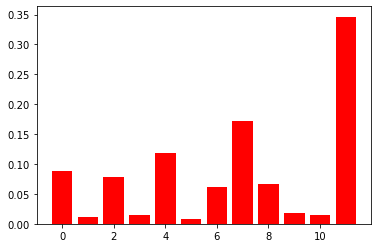

In [76]:
# plot feature importance
plt.bar([x for x in range(len(importance))], importance, color = "red")
plt.show()

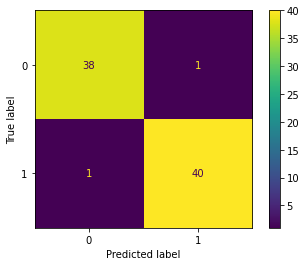

Random Forest Model Accuracy score:  0.975
Random Forest Model F1-score:  0.975609756097561
Random Forest Model Precision score:  0.975609756097561
Random Forest Model Recall score:  0.975609756097561


In [63]:
# Training a Random Forest Classifier using 5 most important features
x_train_random_forest = X_train[["age","creatinine_phosphokinase","ejection_fraction","serum_creatinine","time"]]
x_test_random_forest = X_test[["age","creatinine_phosphokinase","ejection_fraction","serum_creatinine","time"]]

random_forest_model = RandomForestClassifier(max_depth=7, random_state=25)
random_forest_model.fit(x_train_random_forest, Y_train)
y_pred_random_forest = random_forest_model.predict(x_test_random_forest)
cm_random_forest = confusion_matrix(y_pred_random_forest, Y_test)
acc_random_forest = accuracy_score(Y_test, y_pred_random_forest)
f1_random_forest = f1_score(Y_test, y_pred_random_forest)
precision_random_forest = precision_score(Y_test, y_pred_random_forest)
recall_random_forest = recall_score(Y_test, y_pred_random_forest)
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_pred_random_forest)
roc_auc_rf = auc(false_positive_rate, true_positive_rate)

plot_confusion_matrix(random_forest_model,x_test_random_forest, Y_test)
plt.show()

print("Random Forest Model Accuracy score: ", acc_random_forest)
print("Random Forest Model F1-score: ", f1_random_forest)
print("Random Forest Model Precision score: ", precision_random_forest)
print("Random Forest Model Recall score: ", recall_random_forest)
print("Random Forest Model ROC AUC score: ", roc_auc_rf)

[15:48:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


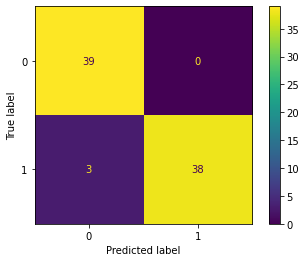

XGBoost Model Accuracy score:  0.9625
XGBoost Model F1-score:  0.9620253164556963
XGBoost Model Precision score:  1.0
XGBoost Model Recall score:  0.926829268292683
XGBoost Model ROC AUC score:  0.9634146341463414
-------------------------------------


In [67]:
#####################################
############XGBoost##################
#####################################

XGB = XGBClassifier(max_depth = 1)
XGB.fit(X_train, Y_train)
y_pred_xgb = XGB.predict(X_test)
cm_xgb = confusion_matrix(y_pred_xgb, Y_test)
acc_xgb = accuracy_score(Y_test, y_pred_xgb)
f1_xgb = f1_score(Y_test, y_pred_xgb)
pre_xgb = precision_score(Y_test, y_pred_xgb)
rec_xgb = recall_score(Y_test, y_pred_xgb)
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_pred_xgb)
roc_auc_xgb = auc(false_positive_rate, true_positive_rate)

plot_confusion_matrix(XGB,X_test, Y_test)
plt.show()

print("XGBoost Model Accuracy score: ", acc_xgb)
print("XGBoost Model F1-score: ", f1_xgb)
print("XGBoost Model Precision score: ", pre_xgb)
print("XGBoost Model Recall score: ", rec_xgb)
print("XGBoost Model ROC AUC score: ", roc_auc_xgb)
print("-------------------------------------")
